In [1]:
import pandas as pd
import numpy as np

import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt

import pickle
import gc

In [2]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# Loading Data

In [3]:
path = "C:/Users/Daniel/Data Science/Workspace/Instacart Market Basket Analysis/2. Prepared Data/"

In [4]:
order_products__prior = pd.read_csv(path + "order_products__prior.csv", dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

order_products__train = pd.read_csv(path + "order_products__train.csv", dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

orders = pd.read_csv(path + "orders.csv", dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

products = pd.read_csv(path + "products.csv", dtype={
        'product_id': np.uint16,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])

In [5]:
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
products.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


# Data Preparation

In [8]:
all_data = orders

order_products = pd.concat([order_products__prior, order_products__train])
all_data = all_data.merge(order_products, on='order_id', how='left')

In [9]:
del order_products__prior, order_products__train, order_products #, products
gc.collect()

229

In [10]:
all_data.sort_values(by=['user_id', 'order_number'], inplace=True)

In [12]:
prior = all_data[all_data.eval_set=='prior']
train = all_data[all_data.eval_set=='train']
test = all_data[all_data.eval_set=='test']

In [13]:
# remove products that were first ordered in the user's last order (we don't have to predict those)
train = train[train.reordered != 0] 

# column not given for test data
train.drop('add_to_cart_order', inplace=True, axis=1)

train.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
59,1187899,1,train,11,4,8,14.0,196.0,1.0
60,1187899,1,train,11,4,8,14.0,25133.0,1.0
61,1187899,1,train,11,4,8,14.0,38928.0,1.0
62,1187899,1,train,11,4,8,14.0,26405.0,1.0
63,1187899,1,train,11,4,8,14.0,39657.0,1.0
64,1187899,1,train,11,4,8,14.0,10258.0,1.0
65,1187899,1,train,11,4,8,14.0,13032.0,1.0
66,1187899,1,train,11,4,8,14.0,26088.0,1.0
68,1187899,1,train,11,4,8,14.0,49235.0,1.0
69,1187899,1,train,11,4,8,14.0,46149.0,1.0


# Creating Train Set for Binary Classification
order_products_train indicates which products were reorders in the user's last order <br>
as negative samples we use all products that were previously purchased by the user and not reordered in his last order

In [14]:
# train.groupby('user_id').product_id.apply(set).head()

In [15]:
train_orders = orders[orders.eval_set=='train']

In [16]:
reorders = train.groupby('user_id').product_id.apply(set) # reorders in the training order
all_products = prior.groupby('user_id').product_id.apply(set) # all previously purchased products

not_reordered = all_products - reorders

In [17]:
order_list = []
product_list=[]
labels = []

In [18]:
for row in train_orders.itertuples():
    try:
        product_list += reorders[row.user_id]
        order_list += [row.order_id] * len(reorders[row.user_id])
        labels += [1] * len(reorders[row.user_id])
        
        product_list += not_reordered[row.user_id]
        order_list += [row.order_id] * len(not_reordered[row.user_id])
        labels += [0] * len(not_reordered[row.user_id])
    except:
        product_list += all_products[row.user_id]
        order_list += [row.order_id] * len(all_products[row.user_id])
        labels += [0] * len(all_products[row.user_id])

In [19]:
train_df = pd.DataFrame()
train_df['order_id'] = order_list
train_df['product_id'] = product_list
train_df['reordered'] = labels

In [20]:
train_df = train_df.merge(orders, how='left')
train_df = train_df.merge(products, how='left')

train_df.drop('eval_set', axis=1, inplace=True)

train_df = train_df[[column for column in train_df if column != 'reordered'] + ['reordered']]

In [21]:
train_df.head(15)

,order_id,product_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,reordered
0,1187899,196.0,1,11,4,8,14.0,77,7,1
1,1187899,26405.0,1,11,4,8,14.0,54,17,1
2,1187899,46149.0,1,11,4,8,14.0,77,7,1
3,1187899,13032.0,1,11,4,8,14.0,121,14,1
4,1187899,39657.0,1,11,4,8,14.0,45,19,1
5,1187899,26088.0,1,11,4,8,14.0,23,19,1
6,1187899,25133.0,1,11,4,8,14.0,21,16,1
7,1187899,38928.0,1,11,4,8,14.0,120,16,1
8,1187899,10258.0,1,11,4,8,14.0,117,19,1
9,1187899,49235.0,1,11,4,8,14.0,53,16,1


# Test Set

In [22]:
test_orders = orders[orders.eval_set=='test']

In [23]:
order_list = []
product_list=[]

In [24]:
for row in test_orders.itertuples():
        product_list += all_products[row.user_id]
        order_list += [row.order_id] * len(all_products[row.user_id])

In [25]:
test_df = pd.DataFrame()
test_df['order_id'] = order_list
test_df['product_id'] = product_list

In [26]:
test_df = test_df.merge(orders, how='left')
test_df = test_df.merge(products, how='left')

test_df.drop('eval_set', axis=1, inplace=True)

In [27]:
test_df.head()

,order_id,product_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,2774568,17668.0,3,13,5,15,11.0,91,16
1,2774568,44683.0,3,13,5,15,11.0,83,4
2,2774568,48523.0,3,13,5,15,11.0,37,1
3,2774568,21903.0,3,13,5,15,11.0,123,4
4,2774568,14992.0,3,13,5,15,11.0,83,4


# Features

## Product Features

In [28]:
prods = pd.DataFrame()

prods['product_orders'] = prior.groupby(prior.product_id).size().astype(np.int32)
prods['product_reorders'] = prior['reordered'].groupby(prior.product_id).sum().astype(np.float32)
prods['product_reorder_rate'] = (prods.product_reorders / prods.product_orders).astype(np.float32)

In [29]:
train_df = train_df.join(prods, on='product_id', how='left')
test_df = test_df.join(prods, on='product_id', how='left')

In [30]:
del prods
gc.collect()

274

## User Features

In [31]:
users = pd.DataFrame()

users['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)

users['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)
users['total_items'] = prior.groupby('user_id').size().astype(np.int16)
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)

users['all_products'] = prior.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

In [32]:
# number of reordered items per user
users['u_reordered'] = prior.groupby('user_id')['reordered'].sum().astype(np.float32)

users['u_reorder_rate'] = users['u_reordered']/users['total_items']

In [33]:
users.drop('all_products', axis=1, inplace=True)

In [34]:
train_df = train_df.join(users, on='user_id', how='left')
test_df = test_df.join(users, on='user_id', how='left')

In [35]:
del users
gc.collect()

63

# User x Product Features

In [36]:
users_prods = pd.DataFrame()

In [37]:
# count how often a user bought each product
users_prods['up_count'] = prior.groupby(['user_id', 'product_id']).size().astype(np.int16)

In [38]:
train_df = train_df.set_index(['user_id', 'product_id'])
train_df = train_df.join(users_prods)

In [39]:
test_df = test_df.set_index(['user_id', 'product_id'])
test_df = test_df.join(users_prods)

In [40]:
del users_prods
gc.collect()

21

# Other Features

### reorder_rate / aisle

In [41]:
prior = prior.merge(products, on='product_id', how='left')

In [42]:
aisles = pd.DataFrame()
aisles['a_reordered'] = prior.groupby('aisle_id')['reordered'].sum().astype(np.float32)
aisles['a_total_items'] = prior.groupby('aisle_id').size().astype(np.float32)
aisles['a_reorder_rate'] = aisles['a_reordered']/aisles['a_total_items']

In [43]:
train_df.reset_index(inplace=True)
train_df = train_df.join(aisles, on='aisle_id', how='left')

In [44]:
test_df.reset_index(inplace=True)
test_df = test_df.join(aisles, on='aisle_id', how='left')

### reorder_rate / department

In [45]:
departments = pd.DataFrame()
departments['d_reordered'] = prior.groupby('department_id')['reordered'].sum().astype(np.float32)
departments['d_total_items'] = prior.groupby('department_id').size().astype(np.float32)
departments['d_reorder_rate'] = departments['d_reordered']/departments['d_total_items']

In [46]:
train_df = train_df.join(departments, on='department_id', how='left')

In [47]:
test_df = test_df.join(departments, on='department_id', how='left')

In [48]:
del aisles, departments
gc.collect()

58

### weekday_sin / weekday_cos

In [49]:
train_df['weekday_sin'] = np.sin(2 * np.pi * train_df['order_dow'] / 7)
train_df['weekday_cos'] = np.cos(2 * np.pi * train_df['order_dow'] / 7)

In [50]:
test_df['weekday_sin'] = np.sin(2 * np.pi * test_df['order_dow'] / 7)
test_df['weekday_cos'] = np.cos(2 * np.pi * test_df['order_dow'] / 7)

### hour_sin / hour_cos

In [51]:
train_df['hour_sin'] = np.sin(2 * np.pi * train_df['order_hour_of_day'] / 24)
train_df['hour_cos'] = np.cos(2 * np.pi * train_df['order_hour_of_day'] / 24)

In [52]:
test_df['hour_sin'] = np.sin(2 * np.pi * test_df['order_hour_of_day'] / 24)
test_df['hour_cos'] = np.cos(2 * np.pi * test_df['order_hour_of_day'] / 24)

In [53]:
train_df['days_since_ratio'] = train_df.days_since_prior_order / train_df.average_days_between_orders
test_df['days_since_ratio'] = test_df.days_since_prior_order / test_df.average_days_between_orders

In [54]:
train_df['up_orders_ratio'] = (train_df['up_count'] / train_df['nb_orders']).astype(np.float32)
test_df['up_orders_ratio'] = (test_df['up_count'] / test_df['nb_orders']).astype(np.float32)

In [55]:
train_df

,user_id,product_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,reordered,...,a_reorder_rate,d_reordered,d_total_items,d_reorder_rate,weekday_sin,weekday_cos,hour_sin,hour_cos,days_since_ratio,up_orders_ratio
0,1,196.0,1187899,11,4,8,14.0,77,7,1,...,0.638832,1757892.0,2690129.0,0.653460,-0.433884,-0.900969,0.866025,-0.500000,0.736842,0.909091
1,1,26405.0,1187899,11,4,8,14.0,54,17,1,...,0.528005,297075.0,738666.0,0.402178,-0.433884,-0.900969,0.866025,-0.500000,0.736842,0.181818
2,1,46149.0,1187899,11,4,8,14.0,77,7,1,...,0.638832,1757892.0,2690129.0,0.653460,-0.433884,-0.900969,0.866025,-0.500000,0.736842,0.272727
3,1,13032.0,1187899,11,4,8,14.0,121,14,1,...,0.571584,398013.0,709569.0,0.560922,-0.433884,-0.900969,0.866025,-0.500000,0.736842,0.272727
4,1,39657.0,1187899,11,4,8,14.0,45,19,1,...,0.573293,1657973.0,2887550.0,0.574180,-0.433884,-0.900969,0.866025,-0.500000,0.736842,0.090909
5,1,26088.0,1187899,11,4,8,14.0,23,19,1,...,0.591986,1657973.0,2887550.0,0.574180,-0.433884,-0.900969,0.866025,-0.500000,0.736842,0.181818
6,1,25133.0,1187899,11,4,8,14.0,21,16,1,...,0.585226,3627221.0,5414016.0,0.669969,-0.433884,-0.900969,0.866025,-0.500000,0.736842,0.727273
7,1,38928.0,1187899,11,4,8,14.0,120,16,1,...,0.686489,3627221.0,5414016.0,0.669969,-0.433884,-0.900969,0.866025,-0.500000,0.736842,0.090909
8,1,10258.0,1187899,11,4,8,14.0,117,19,1,...,0.519170,1657973.0,2887550.0,0.574180,-0.433884,-0.900969,0.866025,-0.500000,0.736842,0.818182
9,1,49235.0,1187899,11,4,8,14.0,53,16,1,...,0.685046,3627221.0,5414016.0,0.669969,-0.433884,-0.900969,0.866025,-0.500000,0.736842,0.181818


In [56]:
gc.collect()

620

# MODEL

## Light GBM

In [57]:
import lightgbm as lgb

### Features to Use

In [58]:
train_df.columns

Index(['user_id', 'product_id', 'order_id', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'aisle_id',
       'department_id', 'reordered', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'average_days_between_orders', 'nb_orders',
       'total_items', 'average_basket', 'total_distinct_items', 'u_reordered',
       'u_reorder_rate', 'up_count', 'a_reordered', 'a_total_items',
       'a_reorder_rate', 'd_reordered', 'd_total_items', 'd_reorder_rate',
       'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos',
       'days_since_ratio', 'up_orders_ratio'],
      dtype='object')

In [59]:
features = ['user_id', 'product_id', 'order_id', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'aisle_id',
       'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'average_days_between_orders', 'nb_orders',
       'total_items', 'average_basket', 'total_distinct_items', 'u_reordered',
       'u_reorder_rate', 'up_count', 'a_reordered', 'a_total_items',
       'a_reorder_rate', 'd_reordered', 'd_total_items', 'd_reorder_rate',
       'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos',
       'days_since_ratio', 'up_orders_ratio']

# score 0.3459324

In [60]:
# features = ['order_number', 'days_since_prior_order', 'product_reorder_rate', 
#             'average_days_between_orders', 'nb_orders', 'total_items', 'total_distinct_items', 'average_basket', 'u_reordered', 
#             'u_reorder_rate', 'up_count', 'a_reorder_rate', 'd_reorder_rate', 'weekday_sin', 'weekday_cos', 
#             'hour_sin', 'hour_cos', 'days_since_ratio', 'up_orders_ratio']
#
# score 0.3443581

In [61]:
X_train = train_df[features]
X_test = test_df[features]

y_train = train_df['reordered']

In [62]:
X_train.head()

,user_id,product_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id,product_orders,...,a_reorder_rate,d_reordered,d_total_items,d_reorder_rate,weekday_sin,weekday_cos,hour_sin,hour_cos,days_since_ratio,up_orders_ratio
0,1,196.0,1187899,11,4,8,14.0,77,7,35791,...,0.638832,1757892.0,2690129.0,0.653460,-0.433884,-0.900969,0.866025,-0.5,0.736842,0.909091
1,1,26405.0,1187899,11,4,8,14.0,54,17,1214,...,0.528005,297075.0,738666.0,0.402178,-0.433884,-0.900969,0.866025,-0.5,0.736842,0.181818
2,1,46149.0,1187899,11,4,8,14.0,77,7,8558,...,0.638832,1757892.0,2690129.0,0.653460,-0.433884,-0.900969,0.866025,-0.5,0.736842,0.272727
3,1,13032.0,1187899,11,4,8,14.0,121,14,3751,...,0.571584,398013.0,709569.0,0.560922,-0.433884,-0.900969,0.866025,-0.5,0.736842,0.272727
4,1,39657.0,1187899,11,4,8,14.0,45,19,5019,...,0.573293,1657973.0,2887550.0,0.574180,-0.433884,-0.900969,0.866025,-0.5,0.736842,0.090909


In [63]:
lgb_train = lgb.Dataset(X_train, y_train)

In [64]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

lgb_model = lgb.train(params, lgb_train, ROUNDS)

In [65]:
# save trained model
pickle.dump(lgb_model, open('lgb_model4', 'wb'))

LGB picked 32 variables and eliminated the other 0 variables


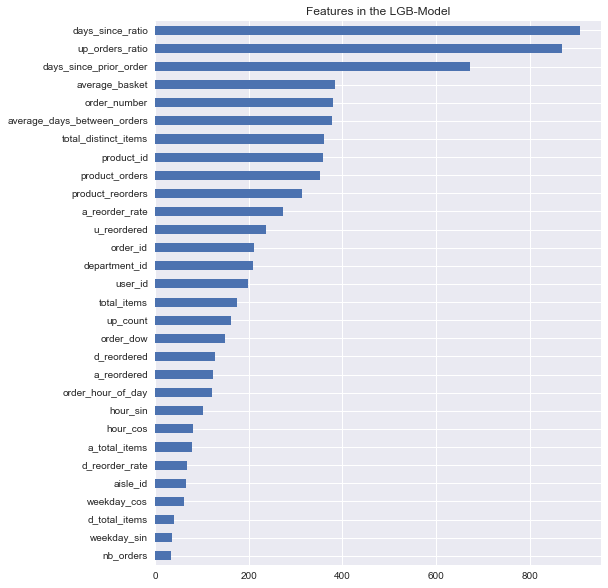

In [66]:
coef = pd.Series(lgb_model.feature_importance(), index = X_train.columns)

print("LGB picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(30), coef.sort_values().tail(0)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Features in the LGB-Model")
plt.show()

In [67]:
lgb_preds = lgb_model.predict(X_test)

In [68]:
pred_df = pd.DataFrame()

pred_df['order_id'] = test_df['order_id']
pred_df['product_id'] = test_df['product_id'].astype(int)

pred_df['preds'] = lgb_preds

pred_df.head()

,order_id,product_id,preds
0,2774568,17668,0.319663
1,2774568,44683,0.134226
2,2774568,48523,0.118045
3,2774568,21903,0.561418
4,2774568,14992,0.144487


In [69]:
train_df.reordered.sum()/len(train_df) 

0.09780025419305857

In [70]:
threshold = 0.2

reordered_preds = pred_df[pred_df.preds > threshold].drop('preds', axis=1)

len(reordered_preds)/len(X_test)

0.12701860346943655

In [71]:
# summarize predicted products for each order_id
d = reordered_preds.groupby('order_id')['product_id'].unique()

# Submission

In [72]:
submission = pd.DataFrame()

submission['order_id'] = test_df['order_id'].unique()
submission['products'] = submission.order_id.map(d)

submission.sort_values(by='order_id', inplace=True)

submission.fillna('None', inplace=True)

In [73]:
# list all reordered items seperated by a space 
submission.products = submission.products.apply(lambda x: " ".join(map(str, x)))

submission.ix[submission.products == 'N o n e', 'products'] ='None'

submission.reset_index(drop=True).head()

,order_id,products
0,17,13107
1,34,39180 21137 47766 47792 39475 47029
2,137,24852 38689 41787 43352 23794
3,182,2078 47672 47209 35951 9337 30391 41149 33000 ...
4,257,4605 24838 29837 37646 21137 24852 47766 30233...


# To CSV

In [74]:
submission.to_csv("submission.csv", index = False)